In [1]:
import os
import torch
import argparse
import itertools
import numpy as np
from tqdm import tqdm
from urllib.request import urlopen
from PIL import Image
import timm
from torch import Tensor
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from glob import glob
from sklearn.model_selection import train_test_split
import pytorch_model_summary as tms
import torch.nn as nn
import random
from torch.nn.modules.batchnorm import _BatchNorm
import torchmetrics
import matplotlib.pyplot as plt
import torch.nn.functional as F
print(f"GPUs used:\t{torch.cuda.device_count()}")
device = torch.device("cuda",5)
print(f"Device:\t\t{device}")

GPUs used:	8
Device:		cuda:5


In [2]:
class_list=['유형1','유형2']
params={'image_size':512,
        'lr':2e-4,
        'beta1':0.5,
        'beta2':0.999,
        'batch_size':8,
        'epochs':1000,
        'n_classes':2,
        'data_path':'../../data/origin_type/BRNT/',
        'inch':3,
        }

In [3]:
trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

def transback(data:Tensor) -> Tensor:
    return data / 2 + 0.5

class CustomDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self,parmas, images,label):
        
        self.images = images
        self.args=parmas
        self.label=label
        
    def trans(self,image):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            image = transform(image)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            image = transform(image)
            
        return image
    
    def __getitem__(self, index):
        image=self.images[index]
        label=self.label[index]
        image = self.trans(image)
        return image,label
    
    def __len__(self):
        return len(self.images)


image_label=[]
image_path=[]
for i in tqdm(range(len(class_list))):
    image_list=glob(params['data_path']+class_list[i]+'/*.jpeg')
    for j in range(len(image_list)):
        image_path.append(image_list[j])
        image_label.append(i)
        
train_images=torch.zeros((len(image_path),params['inch'],params['image_size'],params['image_size']))
for i in tqdm(range(len(image_path))):
    train_images[i]=trans(Image.open(image_path[i]).convert('RGB').resize((params['image_size'],params['image_size'])))
X_train, X_test, y_train, y_test = train_test_split(train_images, image_label, test_size=0.2, random_state=42)
train_dataset=CustomDataset(params,X_train,F.one_hot(torch.tensor(y_train)).to(torch.int64))
val_dataset=CustomDataset(params,X_test,F.one_hot(torch.tensor(y_test)).to(torch.int64))
dataloader=DataLoader(train_dataset,batch_size=params['batch_size'],shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=params['batch_size'],shuffle=True)

100%|██████████| 3722/3722 [01:53<00:00, 32.92it/s]


In [4]:

class FeatureExtractor(nn.Module):
    """Feature extoractor block"""
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        cnn1= timm.create_model('tf_efficientnetv2_xl', pretrained=True)
        self.feature_ex = nn.Sequential(*list(cnn1.children())[:-1])

    def forward(self, inputs):
        features = self.feature_ex(inputs)
        
        return features
class custom_model(nn.Module):
    def __init__(self, num_classes, image_feature_dim,feature_extractor_scale1: FeatureExtractor):
        super(custom_model, self).__init__()
        self.num_classes = num_classes
        self.image_feature_dim = image_feature_dim

        # Remove the classification head of the CNN model
        self.feature_extractor = feature_extractor_scale1
        # Classification layer
        self.classification_layer = nn.Linear(image_feature_dim, num_classes)
        
    def forward(self, inputs):
        batch_size, channels, height, width = inputs.size()
        
        # Feature extraction using the pre-trained CNN
        features = self.feature_extractor(inputs)  # Shape: (batch_size, 2048, 1, 1)
        
        # Classification layer
        logits = self.classification_layer(features)  # Shape: (batch_size, num_classes)
        
        return logits
    
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups
        
def disable_running_stats(model):
    def _disable(module):
        if isinstance(module, _BatchNorm):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)

def enable_running_stats(model):
    def _enable(module):
        if isinstance(module, _BatchNorm) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum
            
import transformers

Feature_Extractor=FeatureExtractor()
model = custom_model(2,1280,Feature_Extractor)
model = model.to(device)
base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=params['lr'], momentum=0.9)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)

epoch: 1/1000 Step: 374 loss : 0.6317 accuracy: 0.6521: 100%|██████████| 373/373 [04:06<00:00,  1.51it/s]
Validation epoch: 1/1000 Step: 95 loss : 0.6526  accuracy: 0.6383: 100%|██████████| 94/94 [00:08<00:00, 10.73it/s]
epoch: 2/1000 Step: 374 loss : 0.5198 accuracy: 0.8107: 100%|██████████| 373/373 [04:02<00:00,  1.54it/s]
Validation epoch: 2/1000 Step: 95 loss : 0.6229  accuracy: 0.7580: 100%|██████████| 94/94 [00:08<00:00, 11.29it/s]
epoch: 3/1000 Step: 374 loss : 0.4937 accuracy: 0.8184: 100%|██████████| 373/373 [03:58<00:00,  1.56it/s]
Validation epoch: 3/1000 Step: 95 loss : 0.6075  accuracy: 0.7912: 100%|██████████| 94/94 [00:07<00:00, 11.90it/s]
epoch: 4/1000 Step: 374 loss : 0.4762 accuracy: 0.8401: 100%|██████████| 373/373 [03:55<00:00,  1.58it/s]
Validation epoch: 4/1000 Step: 95 loss : 0.6059  accuracy: 0.7168: 100%|██████████| 94/94 [00:07<00:00, 11.94it/s]
epoch: 5/1000 Step: 374 loss : 0.4703 accuracy: 0.8422: 100%|██████████| 373/373 [03:55<00:00,  1.58it/s]
Validation

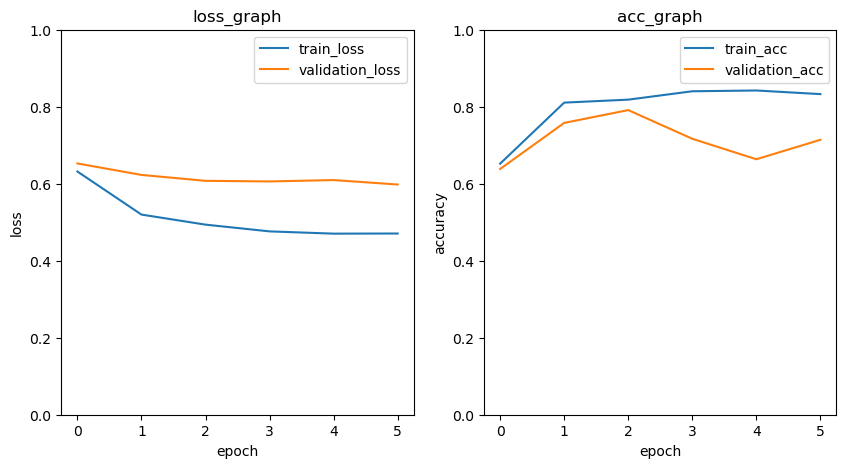

epoch: 7/1000 Step: 374 loss : 0.4542 accuracy: 0.8519: 100%|██████████| 373/373 [03:57<00:00,  1.57it/s]
Validation epoch: 7/1000 Step: 95 loss : 0.5983  accuracy: 0.6928: 100%|██████████| 94/94 [00:07<00:00, 11.79it/s]
epoch: 8/1000 Step: 374 loss : 0.4552 accuracy: 0.8529: 100%|██████████| 373/373 [03:56<00:00,  1.58it/s]
Validation epoch: 8/1000 Step: 95 loss : 0.5827  accuracy: 0.7460: 100%|██████████| 94/94 [00:07<00:00, 11.96it/s]
epoch: 9/1000 Step: 374 loss : 0.4527 accuracy: 0.8525: 100%|██████████| 373/373 [03:55<00:00,  1.58it/s]
Validation epoch: 9/1000 Step: 95 loss : 0.5810  accuracy: 0.7420: 100%|██████████| 94/94 [00:07<00:00, 11.92it/s]
epoch: 10/1000 Step: 374 loss : 0.4434 accuracy: 0.8703: 100%|██████████| 373/373 [03:56<00:00,  1.58it/s]
Validation epoch: 10/1000 Step: 95 loss : 0.5883  accuracy: 0.7048: 100%|██████████| 94/94 [00:07<00:00, 12.02it/s]
epoch: 11/1000 Step: 374 loss : 0.4473 accuracy: 0.8616: 100%|██████████| 373/373 [03:55<00:00,  1.59it/s]
Validat

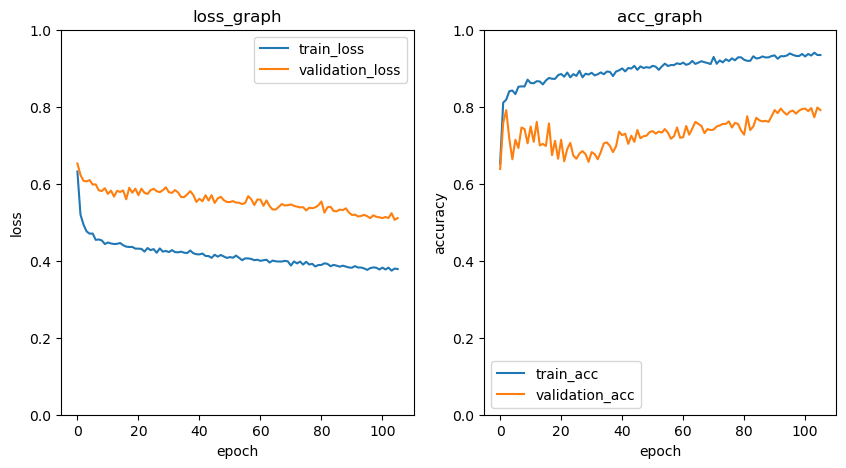

epoch: 107/1000 Step: 374 loss : 0.3788 accuracy: 0.9367: 100%|██████████| 373/373 [03:55<00:00,  1.58it/s]
Validation epoch: 107/1000 Step: 95 loss : 0.5107  accuracy: 0.7965: 100%|██████████| 94/94 [00:07<00:00, 12.02it/s]
epoch: 108/1000 Step: 374 loss : 0.3755 accuracy: 0.9393: 100%|██████████| 373/373 [03:57<00:00,  1.57it/s]
Validation epoch: 108/1000 Step: 95 loss : 0.5131  accuracy: 0.7859: 100%|██████████| 94/94 [00:07<00:00, 11.98it/s]
epoch: 109/1000 Step: 374 loss : 0.3752 accuracy: 0.9410: 100%|██████████| 373/373 [03:56<00:00,  1.58it/s]
Validation epoch: 109/1000 Step: 95 loss : 0.5075  accuracy: 0.8032: 100%|██████████| 94/94 [00:07<00:00, 12.08it/s]
epoch: 110/1000 Step: 374 loss : 0.3782 accuracy: 0.9350: 100%|██████████| 373/373 [03:57<00:00,  1.57it/s]
Validation epoch: 110/1000 Step: 95 loss : 0.5066  accuracy: 0.8019: 100%|██████████| 94/94 [00:07<00:00, 11.96it/s]
epoch: 111/1000 Step: 374 loss : 0.3748 accuracy: 0.9377: 100%|██████████| 373/373 [03:57<00:00,  1.

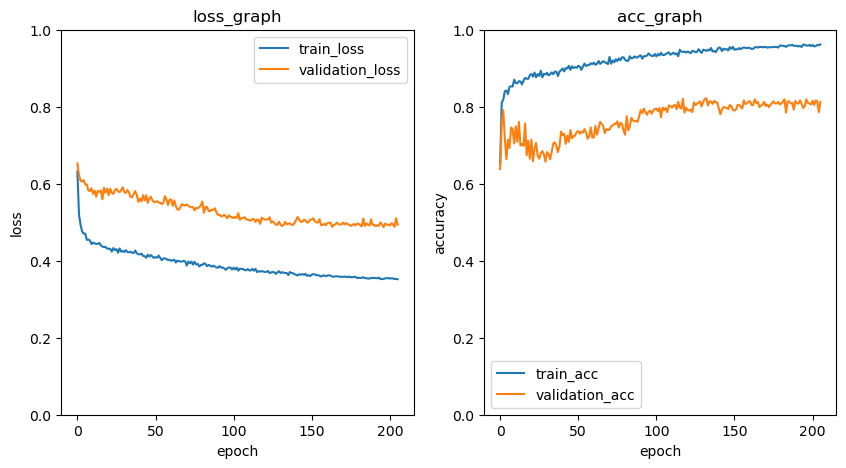

epoch: 207/1000 Step: 374 loss : 0.3509 accuracy: 0.9605: 100%|██████████| 373/373 [03:57<00:00,  1.57it/s]
Validation epoch: 207/1000 Step: 95 loss : 0.4996  accuracy: 0.8059: 100%|██████████| 94/94 [00:10<00:00,  8.81it/s]
epoch: 208/1000 Step: 374 loss : 0.3525 accuracy: 0.9591: 100%|██████████| 373/373 [03:56<00:00,  1.58it/s]
Validation epoch: 208/1000 Step: 95 loss : 0.4951  accuracy: 0.8072: 100%|██████████| 94/94 [00:07<00:00, 11.90it/s]
epoch: 209/1000 Step: 374 loss : 0.3516 accuracy: 0.9621: 100%|██████████| 373/373 [03:58<00:00,  1.56it/s]
Validation epoch: 209/1000 Step: 95 loss : 0.4883  accuracy: 0.8178: 100%|██████████| 94/94 [00:09<00:00, 10.08it/s]
epoch: 210/1000 Step: 374 loss : 0.3503 accuracy: 0.9625: 100%|██████████| 373/373 [04:02<00:00,  1.54it/s]
Validation epoch: 210/1000 Step: 95 loss : 0.5034  accuracy: 0.7979: 100%|██████████| 94/94 [00:07<00:00, 11.97it/s]
epoch: 211/1000 Step: 374 loss : 0.3530 accuracy: 0.9588: 100%|██████████| 373/373 [03:58<00:00,  1.

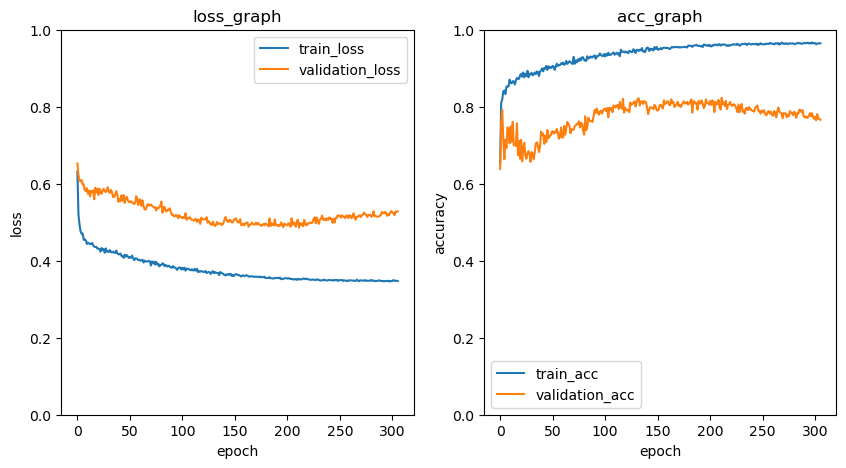

epoch: 307/1000 Step: 374 loss : 0.3466 accuracy: 0.9651: 100%|██████████| 373/373 [03:55<00:00,  1.58it/s]
Validation epoch: 307/1000 Step: 95 loss : 0.5263  accuracy: 0.7673: 100%|██████████| 94/94 [00:07<00:00, 11.99it/s]
epoch: 308/1000 Step: 374 loss : 0.3500 accuracy: 0.9621: 100%|██████████| 373/373 [03:55<00:00,  1.58it/s]
Validation epoch: 308/1000 Step: 95 loss : 0.5251  accuracy: 0.7660: 100%|██████████| 94/94 [00:07<00:00, 12.01it/s]
epoch: 309/1000 Step: 374 loss : 0.3470 accuracy: 0.9655: 100%|██████████| 373/373 [03:56<00:00,  1.58it/s]
Validation epoch: 309/1000 Step: 95 loss : 0.5229  accuracy: 0.7713: 100%|██████████| 94/94 [00:07<00:00, 11.99it/s]
epoch: 310/1000 Step: 374 loss : 0.3470 accuracy: 0.9648: 100%|██████████| 373/373 [03:56<00:00,  1.58it/s]
Validation epoch: 310/1000 Step: 95 loss : 0.5320  accuracy: 0.7660: 100%|██████████| 94/94 [00:07<00:00, 11.80it/s]
epoch: 311/1000 Step: 374 loss : 0.3464 accuracy: 0.9662: 100%|██████████| 373/373 [03:57<00:00,  1.

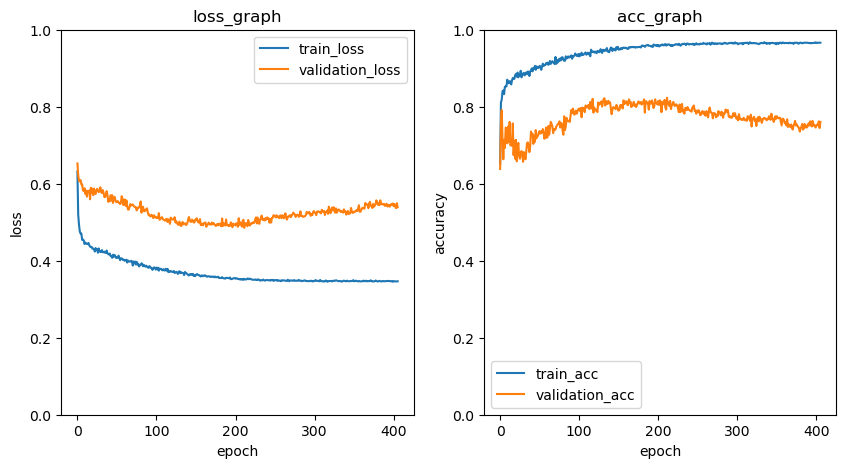

epoch: 407/1000 Step: 374 loss : 0.3467 accuracy: 0.9658: 100%|██████████| 373/373 [03:57<00:00,  1.57it/s]
Validation epoch: 407/1000 Step: 95 loss : 0.5409  accuracy: 0.7566: 100%|██████████| 94/94 [00:08<00:00, 11.75it/s]
epoch: 408/1000 Step: 374 loss : 0.3469 accuracy: 0.9658: 100%|██████████| 373/373 [03:57<00:00,  1.57it/s]
Validation epoch: 408/1000 Step: 95 loss : 0.5362  accuracy: 0.7646: 100%|██████████| 94/94 [00:08<00:00, 11.25it/s]
epoch: 409/1000 Step: 374 loss : 0.3467 accuracy: 0.9651: 100%|██████████| 373/373 [03:59<00:00,  1.56it/s]
Validation epoch: 409/1000 Step: 95 loss : 0.5500  accuracy: 0.7500: 100%|██████████| 94/94 [00:07<00:00, 11.86it/s]
epoch: 410/1000 Step: 374 loss : 0.3470 accuracy: 0.9658: 100%|██████████| 373/373 [03:58<00:00,  1.56it/s]
Validation epoch: 410/1000 Step: 95 loss : 0.5344  accuracy: 0.7713: 100%|██████████| 94/94 [00:11<00:00,  8.50it/s]
epoch: 411/1000 Step: 374 loss : 0.3453 accuracy: 0.9685: 100%|██████████| 373/373 [03:59<00:00,  1.

KeyboardInterrupt: 

In [5]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
sig=nn.Sigmoid()
val_acc_list=[]


for epoch in range(1000):
    train=tqdm(dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    model.train()
    for x, y in train:
        
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        enable_running_stats(model)
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = F.cross_entropy(predict.softmax(dim=1), y) # cost 구함
        acc=accuracy(predict.softmax(dim=1).argmax(dim=1),y.argmax(dim=1))
        cost.backward() # cost에 대한 backward 구함
        optimizer.first_step(zero_grad=True)
        disable_running_stats(model)
        predict = model(x).to(device)
        cost1 = F.cross_entropy(predict.softmax(dim=1), y) # cost 구함
        cost1.backward() # cost에 대한 backward 구함
        optimizer.second_step(zero_grad=True)
        running_loss += cost.item()
        acc_loss+=acc
        train.set_description(f"epoch: {epoch+1}/{1000} Step: {count+1} loss : {running_loss/count:.4f} accuracy: {acc_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count).cpu().detach().numpy())
#validation
    val=tqdm(val_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            predict = model(x).to(device)
            cost = F.cross_entropy(predict.softmax(dim=1), y) # cost 구함
            acc=accuracy(predict.softmax(dim=1).argmax(dim=1),y.argmax(dim=1))
            val_running_loss+=cost.item()
            acc_loss+=acc
            val.set_description(f"Validation epoch: {epoch+1}/{1000} Step: {count+1} loss : {val_running_loss/count:.4f}  accuracy: {acc_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count).cpu().detach().numpy())
    if epoch%100==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
        
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), '../../model/detail_classification/BRNT/Eff_v2_XL_SAM_'+str(epoch)+'.pt')
        MIN_loss=(val_running_loss/count)
torch.save(model.state_dict(), '../../model/detail_classification/BRNT/Eff_v2_XL_SAM.pt')